# Metodo das Linhas

O método das linhas é um método semi-discreto para a resolução de EDP's que consiste em discretizar as variáveis espaciais e manter uma das varáveis contínua (usualmente o tempo), de modo a transformar a EDP em um sistema de EDO's que pode então ser
resolvido através dos métodos para a resolução de PVI's (como os métodos de Runge-Kutta). A abordagem utilizada para a discretização das variáveis espaciais usualmente é o método de diferenças finitas, por isso o método das linhas é muitas vezes chamado de método de diferenças finitas semi-discreto.

Como um exemplo, vamos ver como o método das linhas pode ser utilizado para resolver a equação do calor. A discussão teorica sobre o método das linhas pode ser encontrada no arquivo [em anexo](./assets/material_MOL.pdf). No exemplo resolvido no texto temos a segiunte equação do calor:

$$
\frac{\partial T}{\partial t} = \alpha \frac{\partial^2 T}{\partial x^2} - h' \alpha (T - T_a)
$$

onde $T$ é a temperatura, $t$ é o tempo, $x$ é a posição, $\alpha$ é a difusividade térmica, $h'$ é o coeficiente de transferência de calor por convecção e $T_a$ é a temperatura ambiente. 

<center>
<img src=./images/fig_mol.png>
</center>

As condições de contorno associadas a este problema são:

$$
T(0,t) = T_{ext} \\
\frac{\partial T}{\partial x}|_{x=L} = 0
$$

onde $T_{ext}$ é a temperatura externa e $L$ é o comprimento da barra. As condições iniciais são:

$$
T(x,0) = T_{ini}
$$


Neste caso, será considerado um domínio somente com N = 6 pontos para ilustração:

<center>
<img src=./images/fig_mol1.png>
</center>


Neste caso, a discretização da EDP na direção x irá resultar um conjunto de valores $(T_1, T_2, T_3, T_4, T_5, T_6) que representam a temperatura nos pontos respectivos $(x_1, x_2, x_3, x_4, x_5, x_6)$. Neste caso, porém, estes valores Ti não são constantes, mas podem ser uma função do tempo.

Descritizando o dominio espacial, temos:

$$
\frac{\partial^2 T}{\partial x^2} = \frac{T_{i-1} - 2T_i + T_{i+1}}{\Delta x^2}
$$

subsituindo na equação do calor, temos:

$$
\frac{\partial T_i}{\partial t} = \alpha \frac{T_{i-1} - 2T_i + T_{i+1}}{\Delta x^2} - h' \alpha (T_i - T_a)
$$

Esta equação pode ser aplicada nos pontos i = 2, 3, 4, 5 para obter uma EDO para a temperatura em cada um destes pontos. Para resolver este sistema de EDO's, é preciso definir uma condição inicial para cada ponto. Como a temperatura inicial é considerada
constante e igual a Tini, basta associar este valor com a temperatura em cada ponto:

$$T_i(0) = T_{ini}$$

Para fechar o sistema de equações, é preciso ainda definir equações para $T_0$ e $T_6$, que são obtidas através da aplicação das condições de contorno. A condição $T(0, t) = T_{ext}$ resulta diretamente em:

$$T_1 = T_{ext}$$

Na extremidade $x = L$, a condição é de derivada nula. Neste caso pode-se aplicar um esquema de discretização para trás, de onde se obtém que $T_6 = T_5$. Com estas duas condições extras, o sistema de EDO's pode ser resolvido.

De forma resumida, as equações para os 6 pontos são

<center>
<img src=./images/fig_mol2.png>
</center>

Agora vamos implementar este problema no Python. Primeiro, vamos definir as constantes e as condições iniciais:

$$
\begin{align}
\alpha &= 0.01 \; cm^2/s\\
h' &= 0.1 \; cm^2\\
T_a &= 25 \; C\\
T_{ini} &= 25 \; C\\
T_{ext} &= 100 \; C\\
L &= 1 \; cm\\
\Delta x &= \frac{L}{N-1} \\
\Delta t &= 0.01 \\
\end{align}
$$



In [7]:
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

In [181]:
alpha = 0.01
h = 0.1
T_a = 25.
T_ini = 25.
T_ext = 100.
L = 1.
N = 6
dx = L/(N - 1)
dt = 0.01

duration = 12000
t_eval = np.linspace(0, duration, 1000)

In [219]:
def Eq(t, T):
    Tt = T.copy()

    n = len(Tt) - 1
    
    #Tt[0] = T_ext
    #Tt[-1] = Tt[-2]
    
    for i in range(1, n):
        Tt[i] = alpha * (Tt[i + 1] - 2 * Tt[i] + Tt[i - 1]) / dx ** 2 - h * alpha * (Tt[i] - T_a)
    
    Tt[0] = T_ext
    Tt[-1] = Tt[-2]

    return Tt.copy()

In [220]:
# boundary conditions

T0 = np.ones(N) * T_ini
T0[0] = T_ext
T0[-1] = T0[-2]

res = solve_ivp(Eq, (0, duration), T0, t_eval=t_eval, method='LSODA', max_step=0.1)

In [221]:
res.y.shape

(6, 1000)

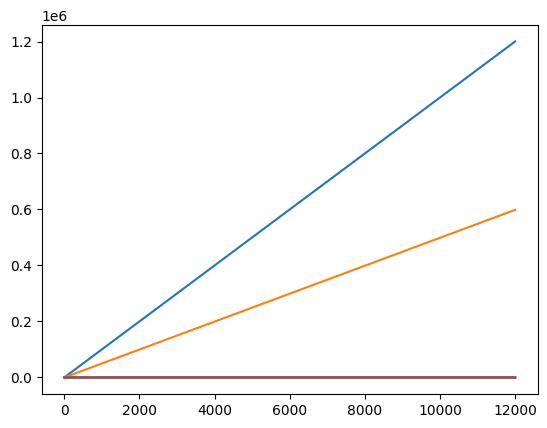

In [222]:
plt.plot(res.t, res.y.T);

In [185]:
res

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.201e+01 ...  1.199e+04  1.200e+04]
        y: [[ 1.000e+02  1.040e+02 ...  1.071e+02  1.258e+02]
            [ 1.875e+01  1.565e+01 ...  1.615e+01  1.936e+01]
            ...
            [-7.910e+00  8.241e-02 ...  8.643e-02  1.152e-01]
            [-7.910e+00  8.241e-02 ...  8.643e-02  1.152e-01]]
      sol: None
 t_events: None
 y_events: None
     nfev: 176618
     njev: 0
      nlu: 0

# Usando o metodo de Euler

In [162]:

def _Euler(Tt, h = dt):
  
    Tt[0] = T_ext
    Tt[-1] = Tt[-2]
    n = len(Tt) - 1

    for i in range(1, n):
        Tt[i] = Tt[i] + h*(alpha * (Tt[i + 1] - 2 * Tt[i] + Tt[i - 1]) / dx ** 2 - h * alpha * (Tt[i] - T_a))

    Tt[0] =T_ext
    Tt[-1] = Tt[-2]

    return Tt

In [163]:
T0 = np.ones(N) * T_a

# boundary conditions
T0[0] = T_ext
T0[-1] = T0[-2]

Tts = [T0.copy()]

for t in range(1, duration):
    Tts.append(_Euler(Tts[-1]).copy())

Tts = np.array(Tts)

In [160]:
Tts.shape

(22000, 6)

In [159]:
Tts[0, :]

array([100.        ,  25.1875    ,  25.00046875,  25.00000117,
        25.        ,  25.        ])

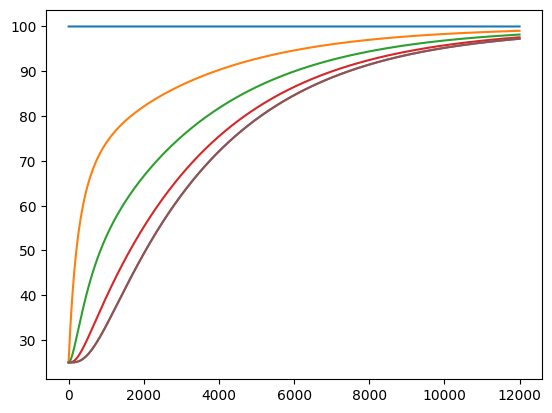

In [164]:
t = np.linspace(0, duration, duration)

plt.plot(t, Tts);

In [ ]:

def Eq(t, x:array):
    n = len(x) - 1
    sol = np.zeros_like(x)
    sol[0] = (U*cin + coef*x[1])/(U+coef)
    sol[-1] = sol[-2]
    print(sol[0])
    # sol = []
    # condição de contorno na entrada do reator
    # sol.append(1/(1+coef)*cin + coef/(1+coef)*x[1])
    
    for i in range(1, n):
        sol[i] = (D*(x[i+1]-2*x[i]+x[i-1])/dx**2 - U*(x[i+1]-x[i-1])/(2*dx) - k*x[i])
    
    # condição de contorno na saida
    #sol[-1] = sol[-2]

    return sol



ci = np.zeros(nx)

# boundary conditions
ci[0] = (U*cin + coef*ci[1])/(U + coef)
ci[-1] = ci[-2]

res = solve_ivp(Eq, (0, 10), ci, t_eval=t_eval, max_step=dx**2/(2*D+k*dx**2))

In [8]:
# Initialisation
T = np.zeros((N, duration))
T[:, 0] = T_ini
T[0, :] = T_ext
T[-1, :] = T_ext

def f(t, T):
    return alpha * (T[i + 1] - 2 * T[i] + T[i - 1]) / dx ** 2

# Rung-Kutta para cada ponto
for i in range(1, N):
    

    sol = solve_ivp(f, [0, duration], T[i, :])
    T[i, :] = sol.y[0]

# Plot
plt.figure(figsize=(10, 5))
plt.plot(T.T)
plt.xlabel('Tempo (s)')
plt.ylabel('Temperatura (°C)')
plt.show()




ValueError: could not broadcast input array from shape (10,) into shape (120,)